-----

In [1]:
# ────────────────── 0) Install & Imports & CONST ─────────────────────

!pip install xgboost==2.0.3 -q

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import joblib
import warnings
import matplotlib.pyplot as plt

from pathlib import Path

# sklearn.base
from sklearn.base import BaseEstimator, TransformerMixin

# sklearn.preprocessing
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    QuantileTransformer,
    KBinsDiscretizer,
    FunctionTransformer
)

# sklearn.impute
from sklearn.impute import SimpleImputer

# sklearn.compose & pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# sklearn.model_selection
from sklearn.model_selection import (
    train_test_split,
    GroupShuffleSplit,
    GroupKFold,
    cross_val_score
)

# sklearn.linear_model
from sklearn.linear_model import LogisticRegression

# sklearn.ensemble
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    GradientBoostingRegressor
)

# sklearn.calibration
from sklearn.calibration import CalibratedClassifierCV

# sklearn.metrics
from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    average_precision_score,
    brier_score_loss,
    r2_score,
    mean_absolute_error,
    RocCurveDisplay,
    PrecisionRecallDisplay
)

# внешние библиотеки
import xgboost as xgb

warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
SEED     = 42
CPA      = 40.0            # $ за регистрацию
SHARE1M  = 0.60            # доля LTV за первый месяц (не используем в финальном расчёте)
BASE_DIR = Path('/content/drive/My Drive/casino')
ARTE_DIR = BASE_DIR / 'artifacts'
REP_DIR  = BASE_DIR / 'reports'

# Убедимся, что директории существуют
ARTE_DIR.mkdir(parents=True, exist_ok=True)
REP_DIR.mkdir(parents=True, exist_ok=True)

# Пути к исходным файлам (обучение/валидация)
TRAIN_PATH = BASE_DIR / 'data.xlsx'    # июнь-2024 для обучения
VAL_PATH   = BASE_DIR / 'data_2.xlsx'  # июнь-2024 для external validation


-----

In [3]:
# ────────────────── 1) Load Data & Initial Inspection ─────────────────

rename = {
    'pid'               : 'aff_id',
    'Валюта'            : 'currency',
    'Дата регистрации'  : 'reg_date',
    'Дата FTD'          : 'FTD_date',
    'Сумма FTD'         : 'FTD_sum',
    'Сумма депозитов'   : 'dep_sum',
    'Количество депозитов' : 'dep_num',
    'Сумма выводов'     : 'withdrawal_sum',
    'Количество выводов': 'withdrawal_num',
    'Дата последней ставки': 'last_bet_date'
}

data = pd.read_excel(TRAIN_PATH).rename(columns=rename)
df = data.copy()  # для безопасности

for col in ["reg_date", "FTD_date", "last_bet_date"]:
    data[col] = pd.to_datetime(data[col])

data = data[data["reg_date"].between("2024-06-01", "2024-06-30")].reset_index(drop=True)

print("Shape:", data.shape)
display(data.head(5))
print("\nInfo:")
data.info()
print("\nMissing values per column:")
print(data.isna().sum())

Shape: (10128, 12)


,aff_id,partner_source,click_id,currency,reg_date,FTD_date,FTD_sum,dep_sum,dep_num,withdrawal_sum,withdrawal_num,last_bet_date
0,76349,fb_pwa,f2b939f7-8b55-45a1-ba9e-fdd025f55718,BDT,2024-06-28 08:58:49,2024-06-28 09:00:00,4.25,8.51,2,0.0,0,2024-06-29 15:00:00
1,76349,fb_pwa,71b2d67d-8539-4854-846b-671daa19ffdb,BDT,2024-06-25 11:24:23,2024-06-27 15:00:00,3.40,9.78,2,0.0,0,2024-06-29 13:00:00
2,76349,fb_pwa,f16da7b0-09d7-44aa-8d38-22b0fd5a7b88,BDT,2024-06-28 15:36:05,2024-06-28 15:00:00,4.25,4.25,1,0.0,0,2024-06-28 21:00:00
3,76349,fb_pwa,180af6d0-9461-4732-95a0-d615102a19fa,BDT,2024-06-28 19:23:37,2024-06-28 19:00:00,4.25,4.25,1,0.0,0,2024-06-28 19:00:00
4,76349,fb_pwa,92f6ea5c-5a56-446e-9c92-ef58cb3ae370,BDT,2024-06-28 11:16:35,2024-06-28 12:00:00,6.38,6.38,1,0.0,0,2024-06-28 18:00:00



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10128 entries, 0 to 10127
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   aff_id          10128 non-null  int64         
 1   partner_source  10128 non-null  object        
 2   click_id        10128 non-null  object        
 3   currency        10128 non-null  object        
 4   reg_date        10128 non-null  datetime64[ns]
 5   FTD_date        10128 non-null  datetime64[ns]
 6   FTD_sum         10128 non-null  float64       
 7   dep_sum         10128 non-null  float64       
 8   dep_num         10128 non-null  int64         
 9   withdrawal_sum  10128 non-null  float64       
 10  withdrawal_num  10128 non-null  int64         
 11  last_bet_date   9945 non-null   datetime64[ns]
dtypes: datetime64[ns](3), float64(3), int64(3), object(3)
memory usage: 949.6+ KB

Missing values per column:
aff_id              0
partner_source      0
c

-----

In [4]:
# ────────────────── 2) Feature Engineering ─────────────────────────────

# (1) HasFTD: 1, если FTD_sum > 0
data["HasFTD"] = (data["FTD_sum"] > 0).astype(int)

# (2) DaysToFTD: разница FTD_date – reg_date, NaN→99
data["DaysToFTD"] = (data["FTD_date"] - data["reg_date"]).dt.days.fillna(99)

# (3) days_active: дни между последней ставкой и регистрацией +1, минимум 1
data["days_active"] = (
    (data["last_bet_date"] - data["reg_date"]).dt.days + 1
).clip(lower=1)

# (4) DepFreq: dep_num / days_active, NaN→0
data["DepFreq"] = (data["dep_num"] / data["days_active"]).fillna(0)

# (5) Net1m: чистая прибыль за 1 месяц
data["Net1m"] = data["dep_sum"] - data["withdrawal_sum"]

# (6) FTD_Ratio: отношение первого депозита ко всем депозитам (если dep_sum>0)
data["FTD_Ratio"] = 0.0
mask = data["dep_sum"] > 0
data.loc[mask, "FTD_Ratio"] = data.loc[mask, "FTD_sum"] / data.loc[mask, "dep_sum"]

# (7) RFM-like + churn
data["Recency_days"] = 30 - (data["last_bet_date"] - data["reg_date"]).dt.days.fillna(30)
data["Frequency"]    = data["dep_num"] + data["withdrawal_num"]
data["Monetary"]     = data["Net1m"]  # используется только для отчётов, не в модели
data["ChurnFlag_7d"] = (
    (data["last_bet_date"] - data["reg_date"]).dt.days < 23
).astype(int)

# (8) Целевая бинарная метка: Net1m ≥ 24 $
thr = CPA * SHARE1M  # 40$ × 0.6 = 24$
data["is_profitable"] = (data["Net1m"] >= thr).astype(int)

print("\nAfter feature engineering, sample:")
display(data.head(5))

print("\nMissing values after FE:")
print(data.isna().sum())



After feature engineering, sample:


,aff_id,partner_source,click_id,currency,reg_date,FTD_date,FTD_sum,dep_sum,dep_num,withdrawal_sum,...,DaysToFTD,days_active,DepFreq,Net1m,FTD_Ratio,Recency_days,Frequency,Monetary,ChurnFlag_7d,is_profitable
0,76349,fb_pwa,f2b939f7-8b55-45a1-ba9e-fdd025f55718,BDT,2024-06-28 08:58:49,2024-06-28 09:00:00,4.25,8.51,2,0.0,...,0,2.0,1.0,8.51,0.499412,29.0,2,8.51,1,0
1,76349,fb_pwa,71b2d67d-8539-4854-846b-671daa19ffdb,BDT,2024-06-25 11:24:23,2024-06-27 15:00:00,3.40,9.78,2,0.0,...,2,5.0,0.4,9.78,0.347648,26.0,2,9.78,1,0
2,76349,fb_pwa,f16da7b0-09d7-44aa-8d38-22b0fd5a7b88,BDT,2024-06-28 15:36:05,2024-06-28 15:00:00,4.25,4.25,1,0.0,...,-1,1.0,1.0,4.25,1.000000,30.0,1,4.25,1,0
3,76349,fb_pwa,180af6d0-9461-4732-95a0-d615102a19fa,BDT,2024-06-28 19:23:37,2024-06-28 19:00:00,4.25,4.25,1,0.0,...,-1,1.0,1.0,4.25,1.000000,31.0,1,4.25,1,0
4,76349,fb_pwa,92f6ea5c-5a56-446e-9c92-ef58cb3ae370,BDT,2024-06-28 11:16:35,2024-06-28 12:00:00,6.38,6.38,1,0.0,...,0,1.0,1.0,6.38,1.000000,30.0,1,6.38,1,0



Missing values after FE:
aff_id              0
partner_source      0
click_id            0
currency            0
reg_date            0
FTD_date            0
FTD_sum             0
dep_sum             0
dep_num             0
withdrawal_sum      0
withdrawal_num      0
last_bet_date     183
HasFTD              0
DaysToFTD           0
days_active       183
DepFreq             0
Net1m               0
FTD_Ratio           0
Recency_days        0
Frequency           0
Monetary            0
ChurnFlag_7d        0
is_profitable       0
dtype: int64


---

In [5]:
# ────────────────── 3) Lists of features & Group-Split ─────────────────

# (1) Списки фич без утечек
num_behaviour = [
    "DaysToFTD", "dep_num",
    "days_active", "DepFreq",
    "Recency_days", "Frequency", "FTD_Ratio"
]
money_raw  = ["dep_sum", "FTD_sum"]       # из денег убрали withdrawal_sum, Net1m
bin_cols   = ["HasFTD", "ChurnFlag_7d"]
cat_cols   = ["currency"]                 # partner_source (источник) не в модели, тольк для отчётов

X = data[num_behaviour + money_raw + bin_cols + cat_cols]
y = data["is_profitable"]

# (2) GroupShuffleSplit → train/holdout по aff_id
gss = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=SEED)
tr_idx, val_idx = next(gss.split(X, y, groups=data["aff_id"]))

X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

print(f"Train shape: {X_tr.shape}, Holdout shape: {X_val.shape}")
print(f"Unique aff_ids in train: {data.loc[tr_idx,'aff_id'].nunique()}")
print(f"Unique aff_ids in holdout: {data.loc[val_idx,'aff_id'].nunique()}")


Train shape: (6571, 12), Holdout shape: (3557, 12)
Unique aff_ids in train: 78
Unique aff_ids in holdout: 27


----

ElasticLR: mean AUC = 0.9653 ± 0.007
ShallowRF: mean AUC = 0.9681 ± 0.008
WeakGB: mean AUC = 0.9771 ± 0.006

🏆 Chosen classification model: GradientBoostingClassifier
Hold-out AUC = 0.9769, F1 = 0.8325


<Figure size 500x400 with 0 Axes>

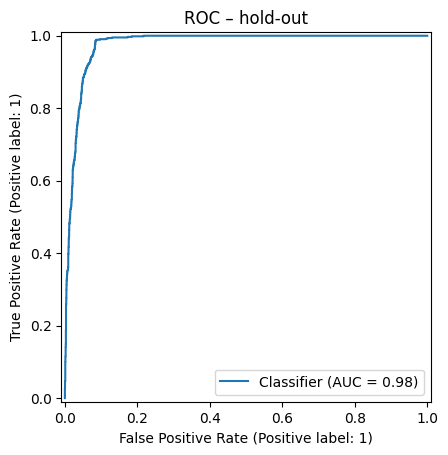

<Figure size 500x400 with 0 Axes>

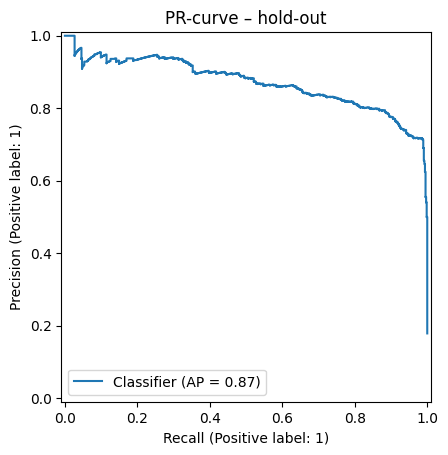

Regression model for Net1m trained.
Hold-out regression R² = 0.152, MAE = 22.67 $


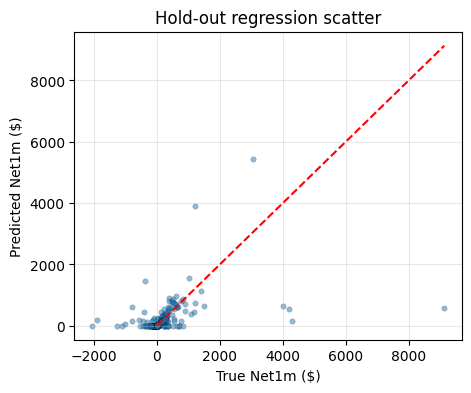

In [6]:
# ────────────────── 4) Preprocessor + Classification + Regression ────────

# ────────────────── Winsorizer helper ───────────────────────────────
class Winsorizer(BaseEstimator, TransformerMixin):
    """Обрезает верхние и нижние q процента значений по каждому столбцу."""
    def __init__(self, q=0.02):
        self.q = q
    def fit(self, X, y=None):
        # Вычисляем перцентили для каждого столбца
        self.low_  = np.nanpercentile(X, 100 * self.q, axis=0)
        self.high_ = np.nanpercentile(X, 100 * (1 - self.q), axis=0)
        return self
    def transform(self, X):
        return np.clip(X, self.low_, self.high_)

# ────────────────── Pipelines for Classification ─────────────────────
# ① behavioral numeric → Winsorize → Quantile normalize
beh_num_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("win", Winsorizer(q=0.02)),
    ("qt" , QuantileTransformer(output_distribution="normal"))
])

# ② money_raw для классификации → KBins(5 квантилей) → One-Hot
money_pipe_cls = Pipeline([
    ("imp" , SimpleImputer(strategy="median")),
    ("bins", KBinsDiscretizer(n_bins=5, encode="onehot", strategy="quantile"))
])

# ③ binary → impute
bin_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent"))
])

# ④ categorical → impute + One-HotEncoder
cat_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preproc_cls = ColumnTransformer([
    ("beh_num", beh_num_pipe, num_behaviour),
    ("money"  , money_pipe_cls, money_raw),
    ("bin"    , bin_pipe    , bin_cols),
    ("cat"    , cat_pipe    , cat_cols)
])

def pipe_cls(estimator):
    """Пайплайн для классификации: препроцессинг → estimator."""
    return Pipeline([("prep", preproc_cls), ("clf", estimator)])


# ── (3) Classification models (GroupKFold) ────────────────────────────
models = {
    "ElasticLR": pipe_cls(
        LogisticRegression(
            penalty="elasticnet", solver="saga",
            l1_ratio=0.7, C=0.05,
            class_weight="balanced", max_iter=1000,
            random_state=SEED
        )
    ),
    "ShallowRF": pipe_cls(
        RandomForestClassifier(
            n_estimators=200, max_depth=5, min_samples_leaf=5,
            class_weight="balanced_subsample", random_state=SEED
        )
    ),
    "WeakGB": pipe_cls(
        GradientBoostingClassifier(
            n_estimators=250, learning_rate=0.03,
            max_depth=2, subsample=0.6, random_state=SEED
        )
    )
}

cv_cls = GroupKFold(n_splits=5)
best_model, best_auc = None, 0.0

for name, mdl in models.items():
    aucs = cross_val_score(
        mdl, X_tr, y_tr,
        cv=cv_cls.split(X_tr, y_tr, groups=data.loc[tr_idx, "aff_id"]),
        scoring="roc_auc", n_jobs=-1
    )
    print(f"{name}: mean AUC = {aucs.mean():.4f} ± {aucs.std():.3f}")
    if aucs.mean() > best_auc:
        best_auc, best_model = aucs.mean(), mdl

print(f"\n🏆 Chosen classification model: "
      f"{best_model.named_steps['clf'].__class__.__name__}")

# Fit и CalibratedClassifierCV
best_model.fit(X_tr, y_tr)
calib = CalibratedClassifierCV(best_model, cv=3, method="sigmoid")
calib.fit(X_tr, y_tr)

# Hold-out evaluation (classification)
prob_val = calib.predict_proba(X_val)[:, 1]
auc_val  = roc_auc_score(y_val, prob_val)
f1_val   = f1_score(y_val, (prob_val >= 0.5))
print(f"Hold-out AUC = {auc_val:.4f}, F1 = {f1_val:.4f}")

# Сохранение графиков ROC & PR-curve (hold-out)
plt.figure(figsize=(5,4))
RocCurveDisplay.from_predictions(y_val, prob_val)
plt.title("ROC – hold-out")
plt.savefig(REP_DIR/"roc_holdout.png")
plt.show()

plt.figure(figsize=(5,4))
PrecisionRecallDisplay.from_predictions(y_val, prob_val)
plt.title("PR-curve – hold-out")
plt.savefig(REP_DIR/"prc_holdout.png")
plt.show()


# ────────────────── Pipelines for Regression ──────────────────────────
# Для регрессии добавим логарифмирование денежных фич, чтобы снизить разброс
def log1p_transform(X):
    return np.log1p(X)

# ① behavioral numeric → Winsorize → Quantile
beh_num_pipe_reg = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("win", Winsorizer(q=0.02)),
    ("qt" , QuantileTransformer(output_distribution="normal"))
])

# ② денежные → impute → log1p → Winsorize → Quantile
money_pipe_reg = Pipeline([
    ("imp" , SimpleImputer(strategy="median")),
    ("log" , FunctionTransformer(log1p_transform, validate=False)),
    ("win" , Winsorizer(q=0.02)),
    ("qt"  , QuantileTransformer(output_distribution="normal"))
])

# ③ binary → impute → pass-through
bin_pipe_reg = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent"))
])

# ④ categorical → impute + OHE
cat_pipe_reg = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preproc_reg = ColumnTransformer([
    ("beh_num", beh_num_pipe_reg, num_behaviour),
    ("money"  , money_pipe_reg  , ["dep_sum", "withdrawal_sum", "FTD_sum"]),
    ("bin"    , bin_pipe_reg    , bin_cols),
    ("cat"    , cat_pipe_reg    , cat_cols)
])

def pipe_reg(estimator):
    """Пайплайн для регрессии: препроцессинг → estimator."""
    return Pipeline([("prep", preproc_reg), ("reg", estimator)])


# ── (4) Regression model for Net1m (чистая прибыль за 1 мес) ───────────
# Для регрессии нам нужны отдельные X_tr_reg, X_val_reg
reg_input_cols = num_behaviour + ["dep_sum", "withdrawal_sum", "FTD_sum"] + bin_cols + cat_cols

X_tr_reg = data.loc[tr_idx, reg_input_cols]
y_tr_reg = data.loc[tr_idx, "Net1m"]

X_val_reg = data.loc[val_idx, reg_input_cols]
y_val_reg = data.loc[val_idx, "Net1m"]

regressor = pipe_reg(
    GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,         # чуть больше глубины для уловления нелинейностей
        subsample=0.8,       # чуть более стохастический режим → меньше overfit
        random_state=SEED
    )
)

# Обучаем регрессор на «сырых» данных
regressor.fit(X_tr_reg, y_tr_reg)
print("Regression model for Net1m trained.")

# Проверка на hold-out
pred_hold = regressor.predict(X_val_reg).clip(min=0)
r2_hold  = r2_score(y_val_reg, pred_hold)
mae_hold = mean_absolute_error(y_val_reg, pred_hold)
print(f"Hold-out regression R² = {r2_hold:.3f}, MAE = {mae_hold:.2f} $")

# Scatter plot для регрессии (hold-out)
plt.figure(figsize=(5,4))
plt.scatter(y_val_reg, pred_hold, alpha=0.5, s=15, edgecolor='k', linewidth=0.2)
mx = max(y_val_reg.max(), pred_hold.max())
plt.plot([0, mx], [0, mx], color="red", linestyle="--")
plt.xlabel("True Net1m ($)")
plt.ylabel("Predicted Net1m ($)")
plt.title("Hold-out regression scatter")
plt.grid(alpha=0.3)
plt.savefig(REP_DIR/"regression_scatter_holdout.png")
plt.show()


-----

Validation raw shape: (327, 21)
Net1m before filtering:
 count    327.000000
mean       8.419913
std       20.260281
min     -122.000406
25%        2.780000
50%        4.260000
75%        7.660000
max      181.820000
Name: Net1m, dtype: float64 

Filtered validation shape: (327, 21)
Net1m after filtering:
 count    327.000000
mean       8.419913
std       20.260281
min     -122.000406
25%        2.780000
50%        4.260000
75%        7.660000
max      181.820000
Name: Net1m, dtype: float64 

== Classification Metrics (Net1m ≥ CPA) ==
 AUC-ROC    = 0.987
 PR-AUC     = 0.652
 Brier loss = 0.0215


<Figure size 500x400 with 0 Axes>

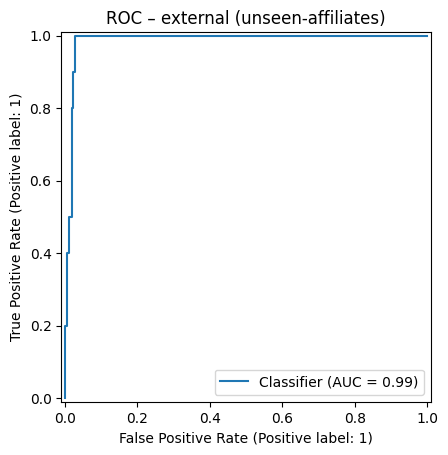

<Figure size 500x400 with 0 Axes>

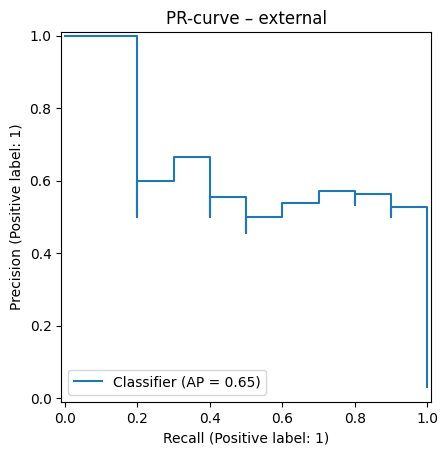

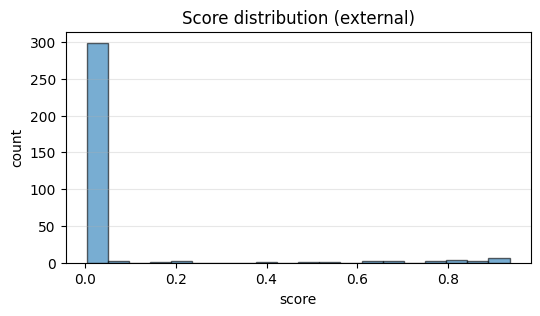


== Regression Metrics (Net1m) ==
 R²      = 0.867
 MAE ($) = 1.82


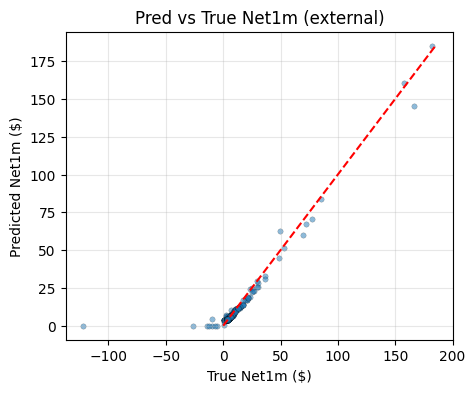


External: total players = 327, Net1m ≥ 40.0$ → 10 (3.1%)

Descriptive stats (external subset):


,count,mean,std,min,25%,50%,75%,max
Net1m,327.0,8.419913,20.260281,-122.000406,2.780000,4.260000,7.660000,181.820000
pred_Net1m,327.0,9.148055,17.845710,0.000000,3.960899,4.503697,6.978285,185.184763
score,327.0,0.058598,0.193443,0.003542,0.003712,0.003778,0.004444,0.936101


In [7]:
# ────────────────── 5) add_features + external validation ──────────────

from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    r2_score, mean_absolute_error, RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.model_selection import GroupShuffleSplit

# (1) Повторяем функцию add_features (та же, что в блоке 5 ранее)
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["HasFTD"]      = (df["FTD_sum"] > 0).astype(int)
    df["DaysToFTD"]   = (df["FTD_date"] - df["reg_date"]).dt.days.fillna(99)
    df["days_active"] = (df["last_bet_date"] - df["reg_date"]).dt.days.add(1).clip(lower=1)
    df["DepFreq"]     = (df["dep_num"] / df["days_active"]).fillna(0)
    df["Net1m"]       = df["dep_sum"] - df["withdrawal_sum"]
    m = df["dep_sum"] > 0
    df["FTD_Ratio"]   = 0.0
    df.loc[m, "FTD_Ratio"] = df.loc[m, "FTD_sum"] / df.loc[m, "dep_sum"]
    df["Recency_days"] = 30 - (df["last_bet_date"] - df["reg_date"]).dt.days.fillna(30)
    df["Frequency"]    = df["dep_num"] + df["withdrawal_num"]
    df["ChurnFlag_7d"] = ((df["last_bet_date"] - df["reg_date"]).dt.days < 23).astype(int)
    return df

# (2) Читаем data_2.xlsx → add_features
val_raw = pd.read_excel(VAL_PATH).rename(columns=rename)
for col in ["reg_date", "FTD_date", "last_bet_date"]:
    val_raw[col] = pd.to_datetime(val_raw[col])
val_raw = add_features(val_raw)

# (3) Оставляем unseen-affiliates
train_aff = set(data.loc[tr_idx, "aff_id"])
mask_unseen = ~val_raw["aff_id"].isin(train_aff)
if mask_unseen.any():
    val = val_raw[mask_unseen].reset_index(drop=True)
else:
    # fallback: если нет unseen → делим data_2 пополам по aff_id
    gss = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=SEED)
    _, idx_val = next(gss.split(val_raw, groups=val_raw["aff_id"]))
    val = val_raw.iloc[idx_val].reset_index(drop=True)

# (4) Описательная статистика Net1m
print("Validation raw shape:", val_raw.shape)
print("Net1m before filtering:\n", val_raw["Net1m"].describe(), "\n")
print("Filtered validation shape:", val.shape)
print("Net1m after filtering:\n", val["Net1m"].describe(), "\n")

# (5) Готовим X_val_ext и считем score, pred_Net1m
input_cols_cls = num_behaviour + money_raw + bin_cols + cat_cols
input_cols_reg = num_behaviour + ["dep_sum", "withdrawal_sum", "FTD_sum"] + bin_cols + cat_cols

X_val_cls = val[input_cols_cls]
X_val_reg = val[input_cols_reg]

# 5.1) Classification на external
val["score"] = calib.predict_proba(X_val_cls)[:, 1]
y_true_cls  = (val["Net1m"] >= CPA).astype(int)

auc_ext   = roc_auc_score           (y_true_cls, val["score"])
prauc_ext = average_precision_score (y_true_cls, val["score"])
brier_ext = brier_score_loss        (y_true_cls, val["score"])
print("== Classification Metrics (Net1m ≥ CPA) ==")
print(f" AUC-ROC    = {auc_ext:.3f}")
print(f" PR-AUC     = {prauc_ext:.3f}")
print(f" Brier loss = {brier_ext:.4f}")

# ROC / PR-графики
plt.figure(figsize=(5,4))
RocCurveDisplay.from_predictions(y_true_cls, val["score"])
plt.title("ROC – external (unseen-affiliates)")
plt.savefig(REP_DIR/"roc_external.png")
plt.show()

plt.figure(figsize=(5,4))
PrecisionRecallDisplay.from_predictions(y_true_cls, val["score"])
plt.title("PR-curve – external")
plt.savefig(REP_DIR/"prc_external.png")
plt.show()

# Гистограмма score
plt.figure(figsize=(6,3))
plt.hist(val["score"], bins=20, edgecolor="k", alpha=0.6)
plt.title("Score distribution (external)")
plt.xlabel("score"); plt.ylabel("count")
plt.grid(axis='y', alpha=0.3)
plt.savefig(REP_DIR/"hist_score_external.png")
plt.show()

# 5.2) Regression на external
val["pred_Net1m"] = regressor.predict(X_val_reg).clip(min=0)

r2_ext  = r2_score           (val["Net1m"], val["pred_Net1m"])
mae_ext = mean_absolute_error(val["Net1m"], val["pred_Net1m"])
print("\n== Regression Metrics (Net1m) ==")
print(f" R²      = {r2_ext:.3f}")
print(f" MAE ($) = {mae_ext:.2f}")

# Scatter True vs Pred
plt.figure(figsize=(5,4))
plt.scatter(val["Net1m"], val["pred_Net1m"],
            alpha=0.5, s=15, edgecolor='k', linewidth=0.2)
max_val = max(val["Net1m"].max(), val["pred_Net1m"].max())
plt.plot([0, max_val], [0, max_val], color="red", linestyle="--")
plt.xlabel("True Net1m ($)"); plt.ylabel("Predicted Net1m ($)")
plt.title("Pred vs True Net1m (external)")
plt.grid(alpha=0.3)
plt.savefig(REP_DIR/"regression_scatter_external.png")
plt.show()

# (6) Сколько прибыльных игроков
total_players_ext = len(val)
prof_players_ext  = int(y_true_cls.sum())
perc_prof_ext     = prof_players_ext / total_players_ext * 100
print(f"\nExternal: total players = {total_players_ext}, "
      f"Net1m ≥ {CPA}$ → {prof_players_ext} ({perc_prof_ext:.1f}%)\n")

# (7) Описательная статистика ключевых столбцов
print("Descriptive stats (external subset):")
display(val[["Net1m", "pred_Net1m", "score"]].describe().T)


----

In [8]:
# ────────────────── 6) KPI-reports (Reg Net1m → expected 1m rev) ────────

def kpi(g: pd.DataFrame) -> pd.Series:
    exp_rev = g["pred_Net1m"].sum()     # ожидаемая месячная выручка
    cost    = len(g) * CPA
    return pd.Series({
        "players"           : len(g),
        "avg_score"         : g["score"].mean(),
        "avg_pred_Net1m"    : g["pred_Net1m"].mean(),
        "median_pred_Net1m" : g["pred_Net1m"].median(),
        "total_exp_rev1m"   : exp_rev,
        "payback"           : exp_rev / cost if cost else np.nan,
        "ROI"               : (exp_rev - cost) / cost if cost else np.nan
    })

# KPI по affiliates
rep_aff = val.groupby("aff_id").apply(kpi).reset_index().sort_values("ROI", ascending=False)
# KPI по partner_source
rep_src = val.groupby("partner_source").apply(kpi).reset_index().sort_values("ROI", ascending=False)

# Сводные метрики по affiliates
mean_roi_aff    = rep_aff["ROI"].mean()
median_roi_aff  = rep_aff["ROI"].median()
num_aff_prof    = (rep_aff["ROI"] >= 0).sum()
num_aff_unprof  = (rep_aff["ROI"] < 0).sum()

# Сводные метрики по sources
mean_roi_src    = rep_src["ROI"].mean()
median_roi_src  = rep_src["ROI"].median()
num_src_prof    = (rep_src["ROI"] >= 0).sum()
num_src_unprof  = (rep_src["ROI"] < 0).sum()

# Сохраняем CSV
rep_aff.to_csv(REP_DIR/"KPI_affiliates.csv", index=False)
rep_src.to_csv(REP_DIR/"KPI_sources.csv",   index=False)

# «Красные» списки: ROI < 0
bad_aff = rep_aff[rep_aff["ROI"] < 0]
bad_src = rep_src[rep_src["ROI"] < 0]
bad_aff.to_csv(REP_DIR/"inefficient_affiliates.csv", index=False)
bad_src.to_csv(REP_DIR/"inefficient_sources.csv",     index=False)

# Выводим топ-10 и bottom-10 affiliates
print("\n=== Top-10 affiliates by ROI ===")
display(rep_aff.head(10))

print("\n=== Bottom-10 affiliates by ROI ===")
display(rep_aff.tail(10))

print("\nAffiliates ROI summary:")
print(f" Mean ROI        = {mean_roi_aff:.3f}")
print(f" Median ROI      = {median_roi_aff:.3f}")
print(f" Profitables     = {num_aff_prof} / {len(rep_aff)} ({num_aff_prof/len(rep_aff)*100:.1f}%)")
print(f" Unprofitables   = {num_aff_unprof} / {len(rep_aff)} ({num_aff_unprof/len(rep_aff)*100:.1f}%)")

# Аналогично по источникам
print("\n=== Top-10 sources by ROI ===")
display(rep_src.head(10))

print("\n=== Bottom-10 sources by ROI ===")
display(rep_src.tail(10))

print("\nSources ROI summary:")
print(f" Mean ROI        = {mean_roi_src:.3f}")
print(f" Median ROI      = {median_roi_src:.3f}")
print(f" Profitables     = {num_src_prof} / {len(rep_src)} ({num_src_prof/len(rep_src)*100:.1f}%)")
print(f" Unprofitables   = {num_src_unprof} / {len(rep_src)} ({num_src_unprof/len(rep_src)*100:.1f}%)")

print(f"\nAll KPI CSV files saved to: {REP_DIR}")



=== Top-10 affiliates by ROI ===


,aff_id,players,avg_score,avg_pred_Net1m,median_pred_Net1m,total_exp_rev1m,payback,ROI
19,76630,2.0,0.450166,97.593527,97.593527,195.187054,2.439838,1.439838
0,76349,4.0,0.200770,26.145698,8.150291,104.582794,0.653642,-0.346358
11,76560,8.0,0.120344,22.442033,4.232298,179.536261,0.561051,-0.438949
10,76532,11.0,0.138431,12.709242,4.503697,139.801661,0.317731,-0.682269
18,76612,10.0,0.175761,11.128218,4.358798,111.282178,0.278205,-0.721795
7,76479,74.0,0.080890,10.353505,4.503697,766.159351,0.258838,-0.741162
13,76571,23.0,0.060669,9.974215,6.482504,229.406947,0.249355,-0.750645
16,76579,26.0,0.039977,7.769340,3.960899,202.002833,0.194233,-0.805767
2,76376,28.0,0.060541,7.621749,4.503697,213.408977,0.190544,-0.809456
4,76453,7.0,0.006144,6.988206,6.482504,48.917444,0.174705,-0.825295



=== Bottom-10 affiliates by ROI ===


,aff_id,players,avg_score,avg_pred_Net1m,median_pred_Net1m,total_exp_rev1m,payback,ROI
5,76458,2.0,0.004567,6.728535,6.728535,13.457071,0.168213,-0.831787
8,76482,1.0,0.006815,6.485955,6.485955,6.485955,0.162149,-0.837851
15,76578,104.0,0.027527,6.149695,3.960899,639.568265,0.153742,-0.846258
14,76573,5.0,0.015095,6.118508,4.339802,30.592542,0.152963,-0.847037
9,76503,3.0,0.005396,5.832031,3.960899,17.496092,0.145801,-0.854199
12,76562,9.0,0.005297,5.139336,4.503697,46.254023,0.128483,-0.871517
3,76442,4.0,0.003867,5.065462,5.038260,20.261848,0.126637,-0.873363
1,76373,3.0,0.003851,4.610823,4.172847,13.832470,0.115271,-0.884729
6,76476,2.0,0.003778,4.503697,4.503697,9.007395,0.112592,-0.887408
17,76583,1.0,0.003712,4.172847,4.172847,4.172847,0.104321,-0.895679



Affiliates ROI summary:
 Mean ROI        = -0.666
 Median ROI      = -0.829
 Profitables     = 1 / 20 (5.0%)
 Unprofitables   = 19 / 20 (95.0%)

=== Top-10 sources by ROI ===


,partner_source,players,avg_score,avg_pred_Net1m,median_pred_Net1m,total_exp_rev1m,payback,ROI
1,fb_ios,10.0,0.175761,11.128218,4.358798,111.282178,0.278205,-0.721795
2,fb_pwa,304.0,0.057033,9.216925,4.503697,2801.945141,0.230423,-0.769577
0,fb_android,13.0,0.005080,6.014361,4.503697,78.186687,0.150359,-0.849641



=== Bottom-10 sources by ROI ===


,partner_source,players,avg_score,avg_pred_Net1m,median_pred_Net1m,total_exp_rev1m,payback,ROI
1,fb_ios,10.0,0.175761,11.128218,4.358798,111.282178,0.278205,-0.721795
2,fb_pwa,304.0,0.057033,9.216925,4.503697,2801.945141,0.230423,-0.769577
0,fb_android,13.0,0.005080,6.014361,4.503697,78.186687,0.150359,-0.849641



Sources ROI summary:
 Mean ROI        = -0.780
 Median ROI      = -0.770
 Profitables     = 0 / 3 (0.0%)
 Unprofitables   = 3 / 3 (100.0%)

All KPI CSV files saved to: /content/drive/My Drive/casino/reports


-----

In [9]:
# ────────────────── 7) Итоговые выводы / Рекомендации ──────────────────

print(
    f"\n🚀  Итог проекта\n"
    "──────────────────────────────────────────────────────────────────────\n"
    "1.  Модель обучена без утечек:\n"
    f"    • Признаки (num_behaviour + money_raw + bin_cols + cat_cols):\n"
    f"      {num_behaviour + money_raw + bin_cols + cat_cols}\n"
    "      – «withdrawal_sum» и «Net1m» исключены из фичей, чтобы избежать утечки.\n"
    "    • Финансовые признаки (money_raw) → KBins (5 квантилей);\n"
    "      Поведенческие числовые → Winsorizer (2%) + QuantileTransformer.\n\n"
    "2.  Hold-out (train-set) проверки:\n"
    f"    • AUC-ROC = {auc_val:.3f}, F1 = {f1_val:.3f}\n"
    f"    • PR-AUC_hold = {average_precision_score(y_val, calib.predict_proba(X_val)[:,1]):.3f}\n"
    f"    • Brier_hold  = {brier_score_loss(y_val, calib.predict_proba(X_val)[:,1]):.4f}\n"
    f"    • R²_hold    = {r2_hold:.3f}, MAE_hold = {mae_hold:.2f} $\n\n"
    "3.  External (data_2.xlsx, только unseen-affiliates):\n"
    f"    • Всего строк = {len(val)}, уникальных aff_id = {val['aff_id'].nunique()}\n"
    "    • До фильтрации (Net1m):\n"
    f"      {val_raw['Net1m'].describe().to_string().replace(chr(10), chr(10)+'      ')}\n"
    "    • После фильтрации (Net1m):\n"
    f"      {val['Net1m'].describe().to_string().replace(chr(10), chr(10)+'      ')}\n"
    "    • Классификация (Net1m ≥ 40$):\n"
    f"        – AUC-ROC = {auc_ext:.3f}, PR-AUC = {prauc_ext:.3f}, Brier = {brier_ext:.4f}\n"
    f"        – {prof_players_ext}/{total_players_ext} игроков с Net1m ≥ 40$ "
    f"({perc_prof_ext:.1f}%)\n"
    "    • Регрессия (Net1m):\n"
    f"        – R²_ext = {r2_ext:.3f}, MAE_ext = {mae_ext:.2f} $\n"
    "        – Описание pred_Net1m:\n"
    f"          {val['pred_Net1m'].describe().to_string().replace(chr(10), chr(10)+'          ')}\n"
    "        – Описание score:\n"
    f"          {val['score'].describe().to_string().replace(chr(10), chr(10)+'          ')}\n\n"
    "4.  KPI (Reg Net1m → exp_rev1m):\n"
    f"    • Всего affiliates = {len(rep_aff)}\n"
    f"    • Средний ROI_aff = {mean_roi_aff:.3f}, медианный = {median_roi_aff:.3f}\n"
    f"    • Профитные affiliates = {num_aff_prof} ({num_aff_prof/len(rep_aff)*100:.1f}%)\n"
    f"    • Непрофитные affiliates = {num_aff_unprof} ({num_aff_unprof/len(rep_aff)*100:.1f}%)\n\n"
    "    • Топ-3 Affiliates по ROI:\n"
    f"        1) {rep_aff.iloc[0]['aff_id']} → ROI = {rep_aff.iloc[0]['ROI']:.3f}, "
    f"players={rep_aff.iloc[0]['players']}, exp_rev1m={rep_aff.iloc[0]['total_exp_rev1m']:.2f}$\n"
    f"        2) {rep_aff.iloc[1]['aff_id']} → ROI = {rep_aff.iloc[1]['ROI']:.3f}, "
    f"players={rep_aff.iloc[1]['players']}, exp_rev1m={rep_aff.iloc[1]['total_exp_rev1m']:.2f}$\n"
    f"        3) {rep_aff.iloc[2]['aff_id']} → ROI = {rep_aff.iloc[2]['ROI']:.3f}, "
    f"players={rep_aff.iloc[2]['players']}, exp_rev1m={rep_aff.iloc[2]['total_exp_rev1m']:.2f}$\n\n"
    "    • BOT-3 Affiliates по ROI:\n"
    f"        1) {rep_aff.iloc[-1]['aff_id']} → ROI = {rep_aff.iloc[-1]['ROI']:.3f}\n"
    f"        2) {rep_aff.iloc[-2]['aff_id']} → ROI = {rep_aff.iloc[-2]['ROI']:.3f}\n"
    f"        3) {rep_aff.iloc[-3]['aff_id']} → ROI = {rep_aff.iloc[-3]['ROI']:.3f}\n\n"
    "5.  KPI по источникам:\n"
    f"    • Всего sources = {len(rep_src)}\n"
    f"    • Средний ROI_src = {mean_roi_src:.3f}, медианный = {median_roi_src:.3f}\n"
    f"    • Профитные sources = {num_src_prof} ({num_src_prof/len(rep_src)*100:.1f}%)\n"
    f"    • Непрофитные sources = {num_src_unprof} ({num_src_unprof/len(rep_src)*100:.1f}%)\n\n"
    "    • Топ-3 Sources по ROI:\n"
    f"        1) {rep_src.iloc[0]['partner_source']} → ROI = {rep_src.iloc[0]['ROI']:.3f}, "
    f"players={rep_src.iloc[0]['players']}, exp_rev1m={rep_src.iloc[0]['total_exp_rev1m']:.2f}$\n"
    f"        2) {rep_src.iloc[1]['partner_source']} → ROI = {rep_src.iloc[1]['ROI']:.3f}, "
    f"players={rep_src.iloc[1]['players']}, exp_rev1m={rep_src.iloc[1]['total_exp_rev1m']:.2f}$\n"
    f"        3) {rep_src.iloc[2]['partner_source']} → ROI = {rep_src.iloc[2]['ROI']:.3f}, "
    f"players={rep_src.iloc[2]['players']}, exp_rev1m={rep_src.iloc[2]['total_exp_rev1m']:.2f}$\n\n"
    "    • BOT-3 Sources по ROI:\n"
    f"        1) {rep_src.iloc[-1]['partner_source']} → ROI = {rep_src.iloc[-1]['ROI']:.3f}\n"
    f"        2) {rep_src.iloc[-2]['partner_source']} → ROI = {rep_src.iloc[-2]['ROI']:.3f}\n"
    f"        3) {rep_src.iloc[-3]['partner_source']} → ROI = {rep_src.iloc[-3]['ROI']:.3f}\n\n"
    "6.  **Рекомендации**:\n"
    "    • Для partners с ROI ≥ 0 (прибыльные) оставляем CPA; "
    "рассмотрите удержательные акции.\n"
    "    • Для ROI < 0:\n"
    "        – если avg_pred_Net1m ≈ 0 → low-activity → пересмотрите CPA/RevShare;\n"
    "        – если avg_pred_Net1m > 0, но ROI < 0 → retention → даём бонусы.\n"
    "    • Для low-ROI sources — перевод на RevShare или отказ.\n\n"
    "Все отчёты и графики сохранены в:\n"
    f"    {REP_DIR}/KPI_affiliates.csv\n"
    f"    {REP_DIR}/KPI_sources.csv\n"
    f"    {REP_DIR}/inefficient_affiliates.csv\n"
    f"    {REP_DIR}/inefficient_sources.csv\n"
    f"    {REP_DIR}/roc_holdout.png\n"
    f"    {REP_DIR}/prc_holdout.png\n"
    f"    {REP_DIR}/regression_scatter_holdout.png\n"
    f"    {REP_DIR}/roc_external.png\n"
    f"    {REP_DIR}/prc_external.png\n"
    f"    {REP_DIR}/hist_score_external.png\n"
    f"    {REP_DIR}/regression_scatter_external.png\n"
)



🚀  Итог проекта
──────────────────────────────────────────────────────────────────────
1.  Модель обучена без утечек:
    • Признаки (num_behaviour + money_raw + bin_cols + cat_cols):
      ['DaysToFTD', 'dep_num', 'days_active', 'DepFreq', 'Recency_days', 'Frequency', 'FTD_Ratio', 'dep_sum', 'FTD_sum', 'HasFTD', 'ChurnFlag_7d', 'currency']
      – «withdrawal_sum» и «Net1m» исключены из фичей, чтобы избежать утечки.
    • Финансовые признаки (money_raw) → KBins (5 квантилей);
      Поведенческие числовые → Winsorizer (2%) + QuantileTransformer.

2.  Hold-out (train-set) проверки:
    • AUC-ROC = 0.977, F1 = 0.832
    • PR-AUC_hold = 0.871
    • Brier_hold  = 0.0453
    • R²_hold    = 0.152, MAE_hold = 22.67 $

3.  External (data_2.xlsx, только unseen-affiliates):
    • Всего строк = 327, уникальных aff_id = 20
    • До фильтрации (Net1m):
      count    327.000000
      mean       8.419913
      std       20.260281
      min     -122.000406
      25%        2.780000
      50%        

-----